In [2]:
import gym
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
env = gym.make('Asterix-ram-v0')
n_episodes = 2000
max_step = 1000

In [4]:
device = 'cuda:0'
policy_net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 9),
                    nn.Softmax()
                    )
policy_net.to(device)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=3e-3)
policy_scheduler = torch.optim.lr_scheduler.StepLR(policy_optimizer, 50, gamma=0.95)

critic_net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(128, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 1)
                    )
critic_net.to(device)
critic_optimizer = torch.optim.Adam(critic_net.parameters(), lr=3e-3)
critic_scheduler = torch.optim.lr_scheduler.StepLR(critic_optimizer, 50, gamma=0.95)

In [5]:
total_rewards = []
freq = max(n_episodes // 20, 1)

In [6]:
eps = 0.1

In [7]:
for episode in range(n_episodes):
    logs = []
    rewards = []
    values = []
    state = torch.tensor(env.reset(), dtype=torch.float32).to(device)
    for step in range(max_step):
        policy = policy_net(state)
        q = np.random.choice(np.arange(2), p=[eps, 1 - eps])
        if q:
            action = np.random.choice(np.arange(9), p=policy.cpu().detach().numpy())
        else:
            action = np.random.randint(9)
        log = torch.log(policy[action] + 1e-6)
        logs.append(log)
        value = critic_net(state)
        values.append(value)
        state, reward, done, info = env.step(action)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        rewards.append(reward)
        if done:
            break
    T = len(rewards)
    #print(rewards[-1])
    total_rewards.append(np.sum(rewards))
    values.append(torch.tensor([0], dtype=torch.float32))
    #G = []
    G = np.zeros_like(rewards)
    Qval = 0.0
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + Qval
        G[t] = Qval
        
    values = torch.stack(values)
    G = torch.FloatTensor(G)
    logs = torch.stack(logs)
        
    #for t in range(T):
        #g = rewards[t] + values[t + 1].cpu().detach().numpy()[0] - values[t].cpu().detach().numpy()[0]
        #G.append(g)
        
    advantage = G - values
    
    critic_loss = 0.5*advantage.pow(2).sum()
    #print(critic_loss)
    actor_loss = -(logs*advantage).sum()
    
    
    policy_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    loss = actor_loss + critic_loss
    #print(loss)
    loss.to(device).backward()
    policy_optimizer.step()
    policy_scheduler.step()
    critic_optimizer.step()
    critic_scheduler.step()
    
    if not episode % freq:
        print('Episode: {}/{} || Reward: {}  Steps: {}'.format(episode, n_episodes, total_rewards[-1], T))
        print('loss:', loss, end = '\n\n')
        #print('value grad', value_grads, end='\n\n')

/home/smomitya/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0/2000 || Reward: 50.0  Steps: 290
loss: tensor(98548944., grad_fn=<AddBackward0>)

Episode: 100/2000 || Reward: 200.0  Steps: 461
loss: tensor(6.7356e+08, grad_fn=<AddBackward0>)

Episode: 200/2000 || Reward: 200.0  Steps: 444
loss: tensor(6.9262e+08, grad_fn=<AddBackward0>)

Episode: 300/2000 || Reward: 150.0  Steps: 433
loss: tensor(1.4456e+08, grad_fn=<AddBackward0>)

Episode: 400/2000 || Reward: 100.0  Steps: 290
loss: tensor(5.1221e+08, grad_fn=<AddBackward0>)

Episode: 500/2000 || Reward: 50.0  Steps: 291
loss: tensor(2.4654e+08, grad_fn=<AddBackward0>)

Episode: 600/2000 || Reward: 300.0  Steps: 548
loss: tensor(1.6233e+09, grad_fn=<AddBackward0>)

Episode: 700/2000 || Reward: 200.0  Steps: 414
loss: tensor(3.4648e+08, grad_fn=<AddBackward0>)

Episode: 800/2000 || Reward: 100.0  Steps: 435
loss: tensor(9.8828e+08, grad_fn=<AddBackward0>)

Episode: 900/2000 || Reward: 150.0  Steps: 469
loss: tensor(4.2204e+08, grad_fn=<AddBackward0>)

Episode: 1000/2000 || Reward: 100.0

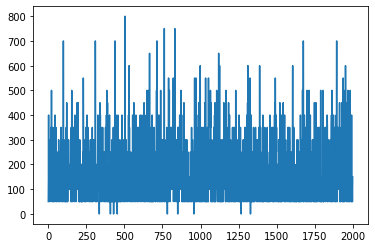

In [8]:
plt.plot(total_rewards);

In [9]:
np.mean(total_rewards)

171.775